# Imports Libraries and Tools

pip install scikit-learn
pip install seaborn
pip install opencv-python-headless


In [57]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data

# Load Datasets

In [58]:
# Directories for training and testing data
train_dir = 'mri-dataset/Training/'
test_dir = 'mri-dataset/Testing/'

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

# Data Visualization

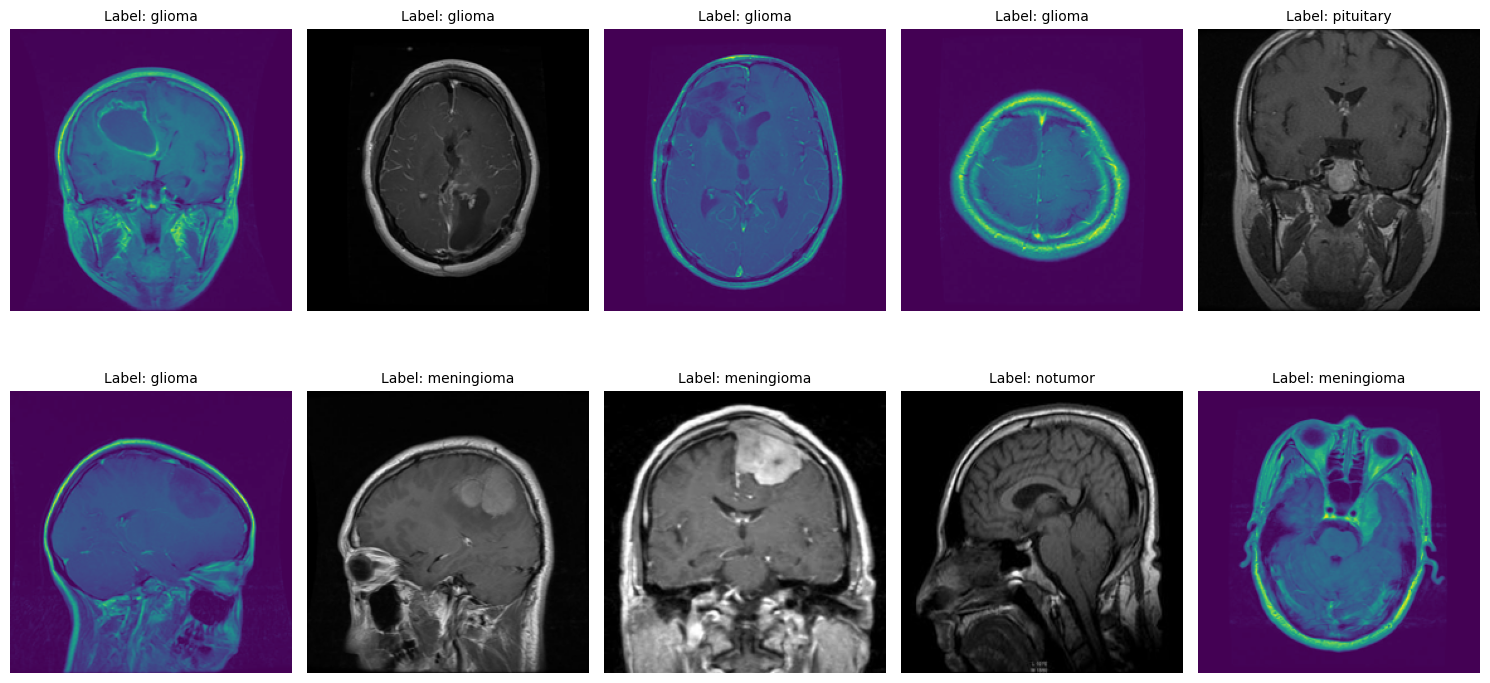

In [59]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()


# Image Preprocessing (Helper Functions)

In [60]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

### Whole Dataset Heatmap (Before Training)

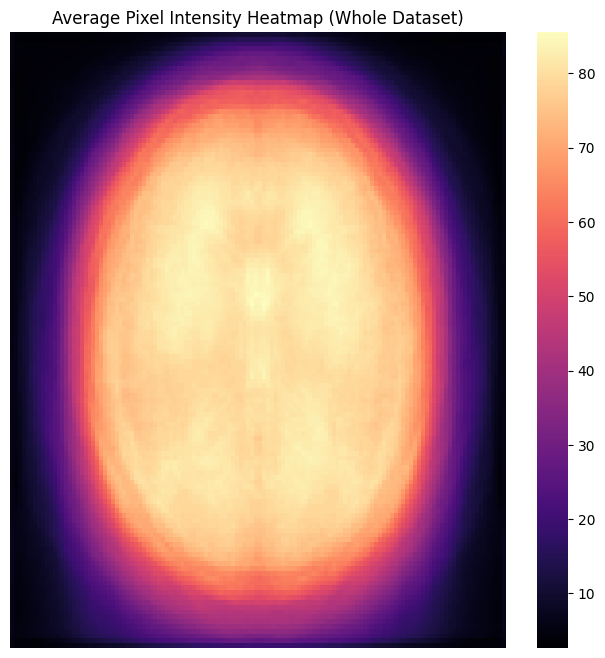

In [61]:
import os
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

# Define dataset path
dataset_path = "mri-dataset/Training/"
image_size = (128, 128)  # Resize images to a common size

# Initialize list to store images
all_images = []

# Loop through each class folder
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    
    if os.path.isdir(class_path):  # Ensure it's a folder
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
            
            if img is not None:
                img = cv2.resize(img, image_size)  # Resize for consistency
                all_images.append(img)

# Convert list to NumPy array and compute mean pixel intensity
all_images = np.array(all_images)
avg_heatmap = np.mean(all_images, axis=0)

# Plot the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(avg_heatmap, cmap="magma", xticklabels=False, yticklabels=False)
plt.title("Average Pixel Intensity Heatmap (Whole Dataset)")
plt.show()


### Data Distribution Check (Class Imbalance)

/tmp/ipykernel_11272/4035238449.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


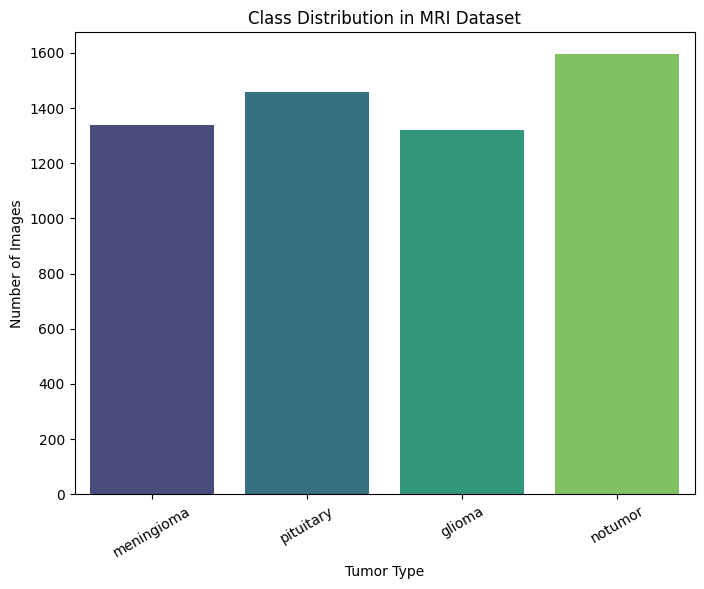

In [62]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define dataset path
dataset_path = "mri-dataset/Training/"

# Count images in each class
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Plot class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.title("Class Distribution in MRI Dataset")
plt.xticks(rotation=30)
plt.show()


### Mean and Standard Deviation of Pixel Intensities

In [63]:
import os
import cv2
import numpy as np

# Define dataset path
dataset_path = "mri-dataset/Training/"

# Initialize variables for mean and std calculation
pixel_sum = 0
pixel_sq_sum = 0
pixel_count = 0

# Process images one by one to avoid memory issues
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read grayscale image
            
            if img is not None:
                img = img.astype(np.float32)  # Convert to float for calculations
                pixel_sum += np.sum(img)
                pixel_sq_sum += np.sum(img ** 2)
                pixel_count += img.size  # Count total pixels

# Compute Mean and Standard Deviation
mean_pixel = pixel_sum / pixel_count
std_pixel = np.sqrt((pixel_sq_sum / pixel_count) - (mean_pixel ** 2))

print(f"Mean Pixel Intensity: {mean_pixel:.2f}")
print(f"Standard Deviation of Pixel Intensity: {std_pixel:.2f}")


Mean Pixel Intensity: 44.22
Standard Deviation of Pixel Intensity: 48.13


### Sample Images from Each Class

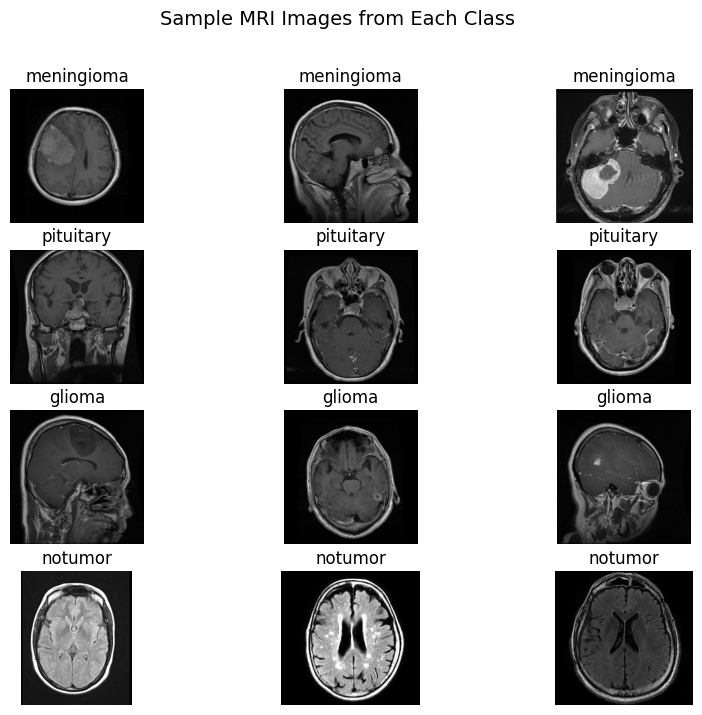

In [64]:
import os
import cv2
import random
import matplotlib.pyplot as plt  # Import Matplotlib

# Define dataset path
dataset_path = "mri-dataset/Training/"

# Show 3 random images from each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        img_names = random.sample(os.listdir(class_path), 3)  # Pick 3 random images
        for j, img_name in enumerate(img_names):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
            if img is not None:
                plt.subplot(4, 3, i * 3 + j + 1)
                plt.imshow(img, cmap="gray")
                plt.axis("off")
                plt.title(class_name)

plt.suptitle("Sample MRI Images from Each Class", fontsize=14)
plt.show()



### Image Histogram Analysis (Pixel Intensity)

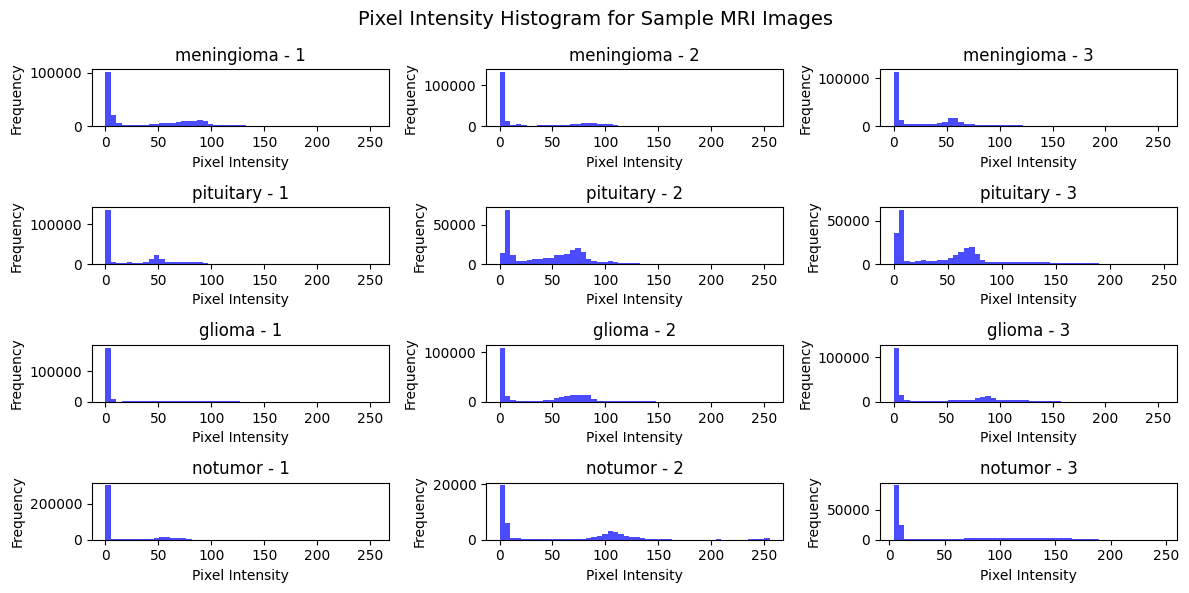

In [65]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define dataset path
dataset_path = "mri-dataset/Training/"

# Plot histograms for a few sample images
plt.figure(figsize=(12, 6))

for i, class_name in enumerate(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        img_names = os.listdir(class_path)[:3]  # Pick 3 images from each class
        for j, img_name in enumerate(img_names):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load grayscale image
            
            if img is not None:
                plt.subplot(4, 3, i * 3 + j + 1)
                plt.hist(img.ravel(), bins=50, color='blue', alpha=0.7)
                plt.title(f"{class_name} - {j+1}")
                plt.xlabel("Pixel Intensity")
                plt.ylabel("Frequency")

plt.suptitle("Pixel Intensity Histogram for Sample MRI Images", fontsize=14)
plt.tight_layout()
plt.show()


### Corrupted or Low-Quality Image Detection

In [66]:
import cv2

corrupted_images = []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is None or img.size == 0:  # Check if image is empty/corrupted
                corrupted_images.append(img_path)

print(f"Total Corrupted Images: {len(corrupted_images)}")
if corrupted_images:
    print("Example corrupted images:", corrupted_images[:5])


Total Corrupted Images: 0


### Edge Detection to Highlight Tumors

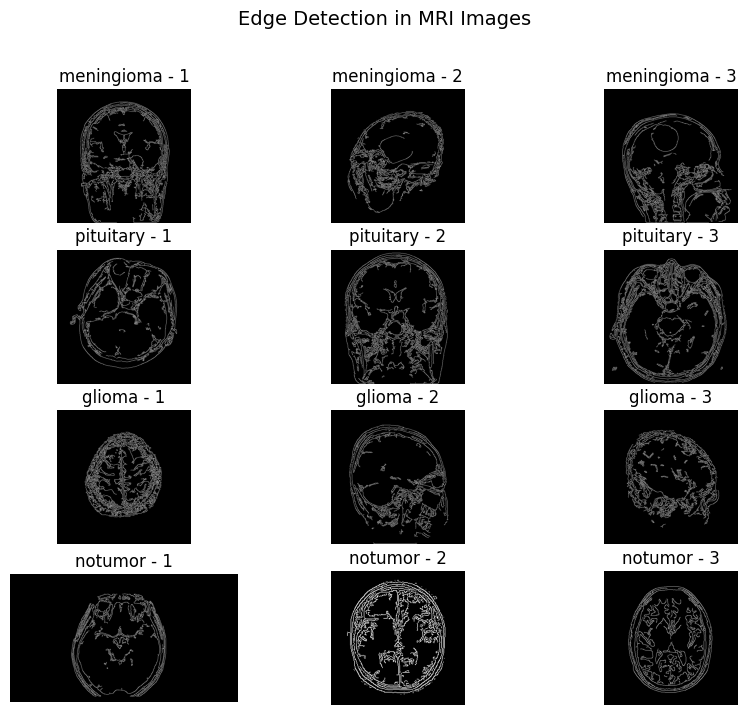

In [67]:
import cv2
import matplotlib.pyplot as plt

# Show edge detection on 3 sample images from each class
plt.figure(figsize=(10, 8))

for i, class_name in enumerate(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        img_names = os.listdir(class_path)[:3]  # Select 3 images
        for j, img_name in enumerate(img_names):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if img is not None:
                edges = cv2.Canny(img, 50, 150)  # Apply Canny Edge Detection
                
                plt.subplot(4, 3, i * 3 + j + 1)
                plt.imshow(edges, cmap="gray")
                plt.axis("off")
                plt.title(f"{class_name} - {j+1}")

plt.suptitle("Edge Detection in MRI Images", fontsize=14)
plt.show()


### Check for Duplicate Images

In [68]:
import hashlib

def get_image_hash(image_path):
    """Compute hash of an image to detect duplicates."""
    with open(image_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

image_hashes = {}
duplicate_images = []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img_hash = get_image_hash(img_path)

            if img_hash in image_hashes:
                duplicate_images.append((img_path, image_hashes[img_hash]))
            else:
                image_hashes[img_hash] = img_path

print(f"Total Duplicate Images Found: {len(duplicate_images)}")
if duplicate_images:
    print("Example duplicates:", duplicate_images[:5])


Total Duplicate Images Found: 191
Example duplicates: [('mri-dataset/Training/meningioma/Tr-me_0211.jpg', 'mri-dataset/Training/meningioma/Tr-me_0366.jpg'), ('mri-dataset/Training/meningioma/Tr-me_0176.jpg', 'mri-dataset/Training/meningioma/Tr-me_0366.jpg'), ('mri-dataset/Training/meningioma/Tr-me_0617.jpg', 'mri-dataset/Training/meningioma/Tr-me_0616.jpg'), ('mri-dataset/Training/meningioma/Tr-me_0175.jpg', 'mri-dataset/Training/meningioma/Tr-me_0281.jpg'), ('mri-dataset/Training/meningioma/Tr-me_0238.jpg', 'mri-dataset/Training/meningioma/Tr-me_0227.jpg')]


### Generate a Heatmap of Image Mean Intensities

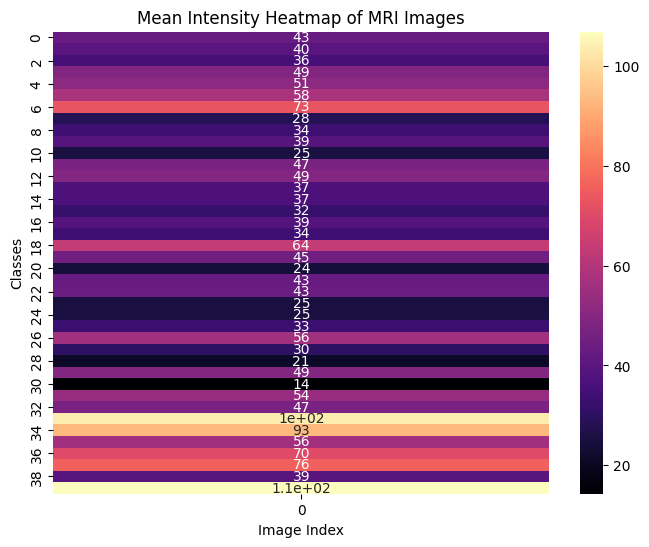

In [69]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize an empty array for mean intensities
mean_images = []

# Load images and compute mean pixel values
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        img_names = os.listdir(class_path)[:10]  # Use first 10 images from each class
        for img_name in img_names:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                mean_images.append(img.mean())

# Convert to NumPy array and reshape for heatmap
mean_images = np.array(mean_images).reshape(-1, 1)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(mean_images, annot=True, cmap="magma", cbar=True)
plt.title("Mean Intensity Heatmap of MRI Images")
plt.xlabel("Image Index")
plt.ylabel("Classes")
plt.show()


###  Check Image Size Distribution

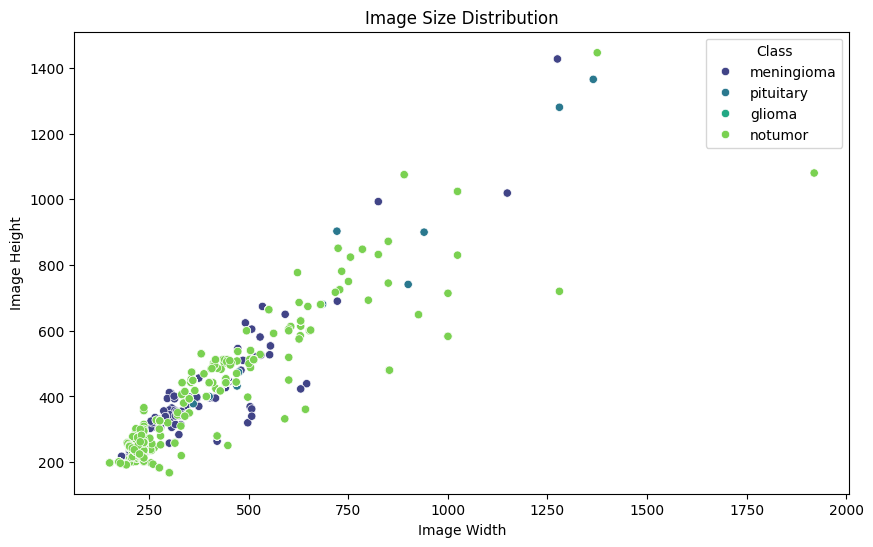

                Height                   Width            
                  mean         std        mean         std
Class                                                     
glioma      512.000000    0.000000  512.000000    0.000000
meningioma  495.233757   72.415302  493.393577   75.804275
notumor     320.733542  156.342905  313.947962  167.319780
pituitary   508.952642   48.981983  508.974605   49.185817


In [70]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define dataset path
dataset_path = "mri-dataset/Training/"

# Store image sizes
image_sizes = []

# Iterate over each class folder
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale

            if img is not None:
                h, w = img.shape  # Get height and width
                image_sizes.append((class_name, h, w))

# Convert to DataFrame
df_sizes = pd.DataFrame(image_sizes, columns=["Class", "Height", "Width"])

# Plot distribution of image sizes
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_sizes, x="Width", y="Height", hue="Class", palette="viridis")
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.title("Image Size Distribution")
plt.show()

# Print summary statistics
print(df_sizes.groupby("Class").agg({"Height": ["mean", "std"], "Width": ["mean", "std"]}))


### Check Image Resolution Sizes


🔍 **Unique Image Resolutions & Their Counts:**
Resolution (512, 512): 3955 images
Resolution (410, 304): 1 images
Resolution (207, 201): 1 images
Resolution (225, 225): 268 images
Resolution (251, 201): 43 images
Resolution (237, 212): 2 images
Resolution (306, 278): 1 images
Resolution (216, 216): 1 images
Resolution (223, 226): 1 images
Resolution (331, 272): 1 images
Resolution (216, 224): 1 images
Resolution (442, 442): 37 images
Resolution (527, 552): 1 images
Resolution (264, 420): 1 images
Resolution (439, 645): 1 images
Resolution (340, 291): 1 images
Resolution (251, 205): 1 images
Resolution (314, 329): 1 images
Resolution (220, 215): 1 images
Resolution (412, 300): 1 images
Resolution (395, 341): 2 images
Resolution (522, 513): 1 images
Resolution (245, 206): 1 images
Resolution (423, 630): 1 images
Resolution (396, 402): 1 images
Resolution (354, 289): 1 images
Resolution (307, 257): 1 images
Resolution (394, 295): 1 images
Resolution (624, 491): 1 images
Resolution (248, 

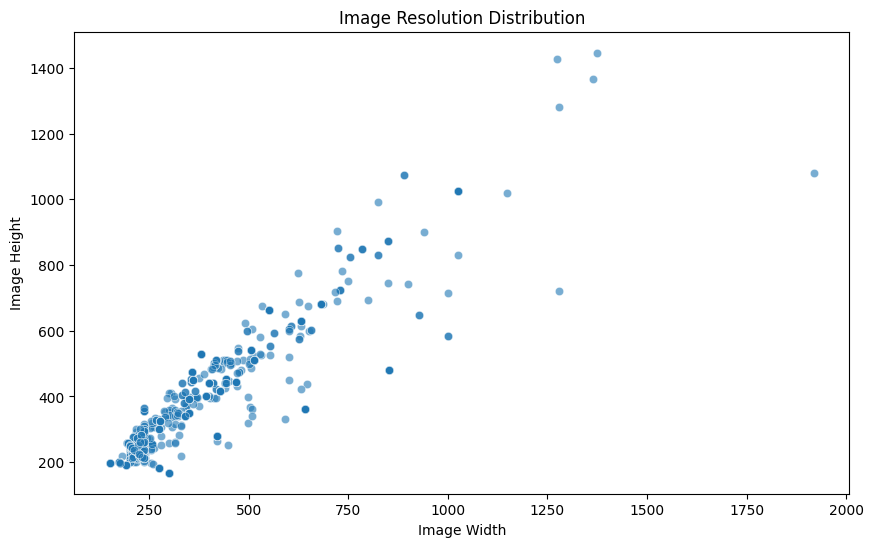


📊 **Resolution Statistics:**
            Height        Width
count  5712.000000  5712.000000
mean    453.883754   451.563200
std     124.779164   131.004291
min     168.000000   150.000000
25%     442.000000   441.000000
50%     512.000000   512.000000
75%     512.000000   512.000000
max    1446.000000  1920.000000


In [71]:
import os
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Define dataset path
dataset_path = "mri-dataset/Training/"

# Store resolution sizes
resolutions = []

# Iterate over each class folder
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale

            if img is not None:
                h, w = img.shape  # Get height and width
                resolutions.append((h, w))  # Store resolution

# Convert resolutions to a DataFrame
df_resolutions = pd.DataFrame(resolutions, columns=["Height", "Width"])

# Count unique resolutions
resolution_counts = Counter(resolutions)
print("\n🔍 **Unique Image Resolutions & Their Counts:**")
for res, count in resolution_counts.items():
    print(f"Resolution {res}: {count} images")

# Plot resolution distribution
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_resolutions, x="Width", y="Height", alpha=0.6)
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.title("Image Resolution Distribution")
plt.show()

# Print summary statistics
print("\n📊 **Resolution Statistics:**")
print(df_resolutions.describe())


# MODEL:

## WE ARE USING VGG16 FOR TRANSFER LEARNING.

In [96]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 88s 302ms/step - loss: 0.6433 - sparse_categorical_accuracy: 0.7390
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.2580 - sparse_categorical_accuracy: 0.8925
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - loss: 0.1739 - sparse_categorical_accuracy: 0.9326
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - loss: 0.1381 - sparse_categorical_accuracy: 0.9473
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0904 - sparse_categorical_accuracy: 0.9670


# Train and Val Plots

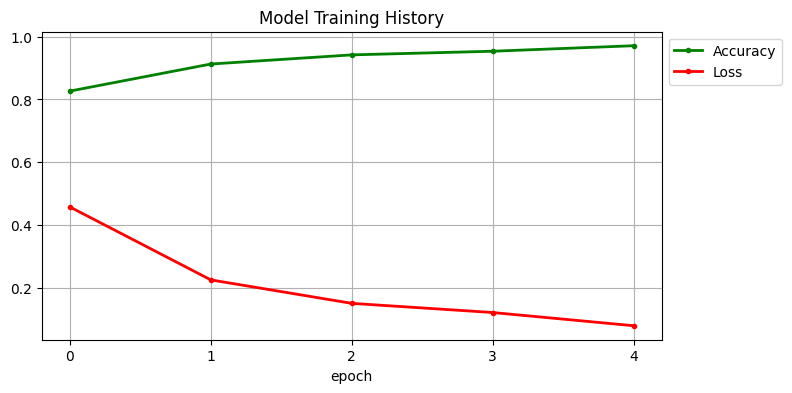

In [97]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Model Classification Report

In [98]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       306
           1       0.98      0.98      0.98       300
           2       0.98      0.84      0.90       300
           3       0.91      1.00      0.95       405

    accuracy                           0.94      1311
   macro avg       0.95      0.94      0.94      1311
weighted avg       0.95      0.94      0.94      1311



# Model Confusion Plot

Confusion Matrix:
[[285   3   5  13]
 [  2 295   1   2]
 [ 20   2 252  26]
 [  0   0   0 405]]


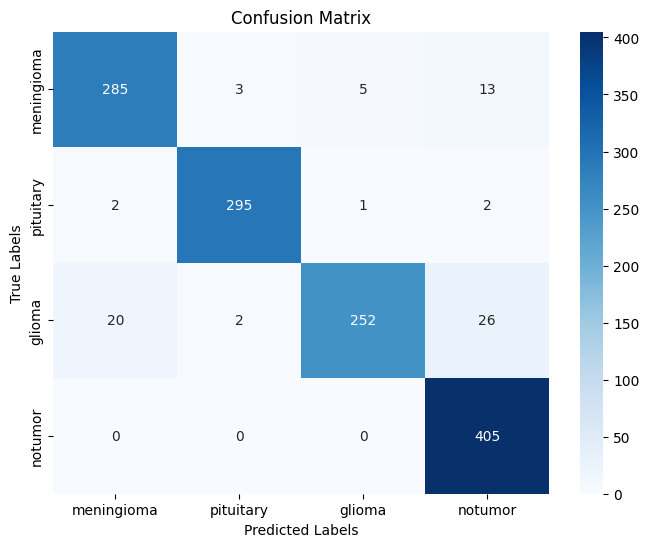

In [99]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Roc Curve Plot


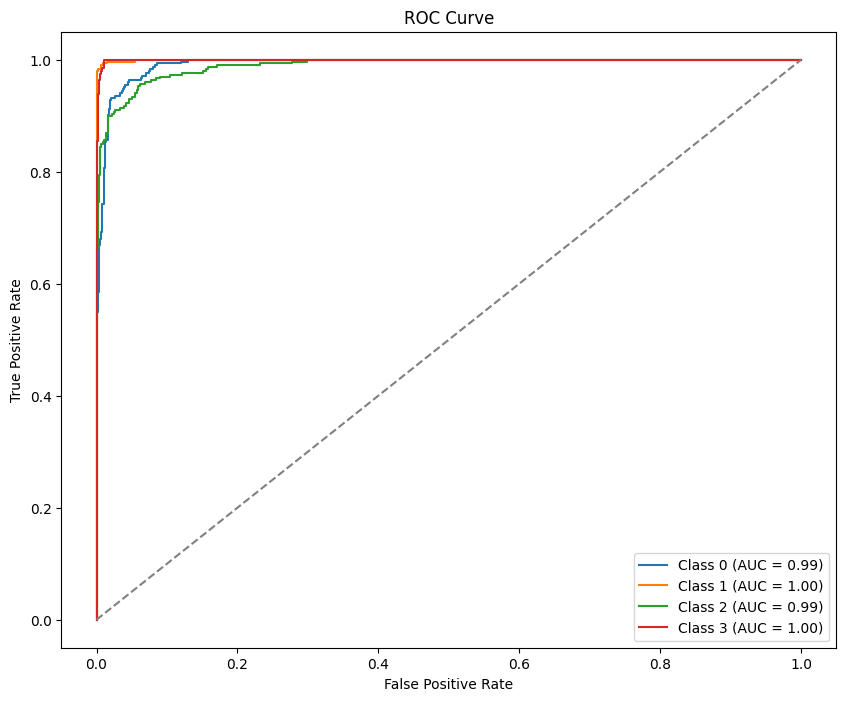

In [100]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Save & Load Model

In [101]:
# Save the entire model
model.save('model.h5')

In [102]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

# MRI Tumor Detection System

In [103]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


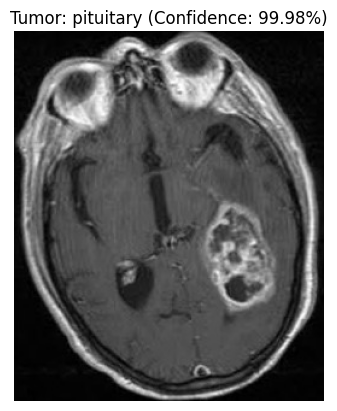

In [104]:
# Example usage
image_path = 'mri-dataset/Testing/meningioma/Te-meTr_0001.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

In [112]:

# Example usage
image_path = 'mri-dataset/Testing/notumor/Te-no_0211.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

Error processing the image: Input 0 of layer "vgg16" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 128, 128, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


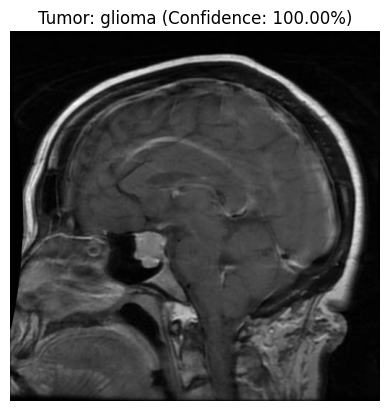

In [106]:
# Example usage
image_path = 'mri-dataset/Testing/pituitary/Te-piTr_0005.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


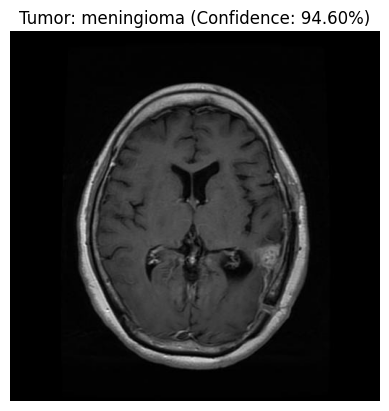

In [107]:
# Example usage
image_path = 'mri-dataset/Testing/glioma/Te-gl_0019.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

# GRAD_CAM

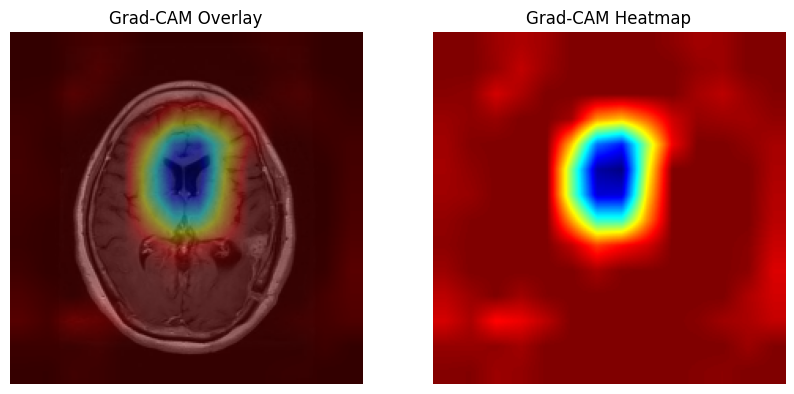

In [108]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

# Load VGG16 model
model = VGG16(weights='imagenet', include_top=True)
grad_model = Model(inputs=model.input, outputs=[model.get_layer("block5_conv3").output, model.output])

def compute_gradcam(img_path, model, layer_name="block5_conv3"):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize to match VGG16 input
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    # ✅ Ensure gradients are tracked
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img, training=False)  # Run model inside tape
        class_idx = np.argmax(predictions)  # Get predicted class
        loss = predictions[:, class_idx]  # Focus on the predicted class

    grads = tape.gradient(loss, conv_outputs)  # Compute gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Global average pooling

    conv_outputs = conv_outputs[0]  # Remove batch dimension
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)  # Weighted activation
    heatmap = np.maximum(heatmap, 0)  # Apply ReLU
    heatmap /= np.max(heatmap)  # Normalize

    # ✅ FIXED: Ensure proper NumPy conversion
    heatmap = heatmap.numpy() if isinstance(heatmap, tf.Tensor) else heatmap
    heatmap = cv2.resize(heatmap, (224, 224))  # Resize heatmap to image size
    heatmap = np.uint8(255 * heatmap)  # Convert to 0-255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply colormap

    # Superimpose heatmap on the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize again for overlay
    superimposed_img = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0.6, heatmap, 0.4, 0)

    return superimposed_img, heatmap

# Test Grad-CAM on an MRI image
img_path = "mri-dataset/Testing/glioma/Te-gl_0019.jpg"  # Change to your actual image path
gradcam_img, heatmap = compute_gradcam(img_path, model)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(gradcam_img)
plt.axis("off")
plt.title("Grad-CAM Overlay")

plt.subplot(1, 2, 2)
plt.imshow(heatmap)
plt.axis("off")
plt.title("Grad-CAM Heatmap")

plt.show()


In [84]:
# Load model
model = load_model("model.h5")

# Print layer names
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,910 (60.13 MB)

 Trainable params: 8,128,644 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 2 (12.00 B)